In [ ]:
%pip install scvi-tools hyperopt "ray[tune]" anndata2ri

In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
from ray import tune
from scvi import autotune


/home/sapien/anaconda3/envs/integ/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [ ]:
from scvi.autotune import run_autotune
from ray import tune

In [ ]:
%pip install -U scvi-tools[optional]

In [ ]:
%pip install -U ipywidgets

In [ ]:
print(f"scVI version: {scvi.__version__}")


In [ ]:
print(dir(scvi.autotune))

In [3]:
adata = sc.read('unintigrated.h5ad')
adata

AnnData object with n_obs × n_vars = 19787 × 33694
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'low_label', 'low_score'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')
adata

AnnData object with n_obs × n_vars = 19787 × 3000
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'low_label', 'low_score'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [5]:
sc.pp.filter_genes(adata, min_cells = 50)
adata

AnnData object with n_obs × n_vars = 19787 × 2511
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'low_label', 'low_score'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'hvg'

In [ ]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys = ['samples'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

tuner = ModelTuner(model_cls)

In [6]:
scvi.model.SCVI.setup_anndata(adata,
                              categorical_covariate_keys = ['samples'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

In [7]:
model = scvi.model.SCVI(adata, n_hidden = 256, n_latent = 30, n_layers = 2, gene_likelihood = 'zinb')

In [8]:
kwargs = {'lr': 0.0020}

In [9]:
model.train(max_epochs = 150, early_stopping = True, plan_kwargs = kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [10]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3012433 stored elements and shape (19787, 2511)>

In [11]:
model = scvi.model.SCVI.load('the_model/', adata)

INFO     File the_model/model.pt already downloaded                                                                


In [12]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

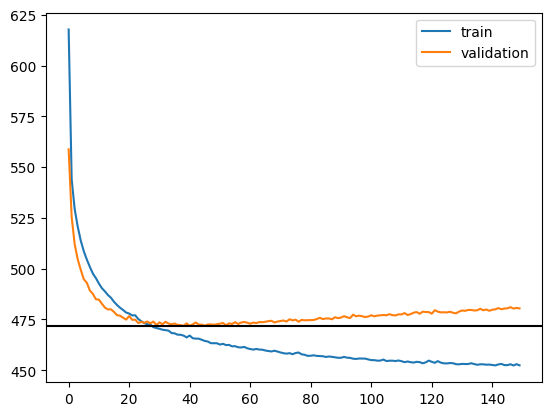

In [13]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [14]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [15]:
adata.obsm['X_scVI'].shape

(19787, 30)

In [16]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [17]:
sc.tl.leiden(adata, resolution = 3, key_added = 'overcluster')

In [18]:
sc.tl.umap(adata)

In [19]:
adata.layers['counts'] = adata.X.copy()

In [21]:
adata.var

,highly_variable,highly_variable_rank,means,variances,variances_norm,n_cells
SAMD11,True,2646.0,0.017587,0.042751,1.536382,202
HES4,True,1956.0,0.358266,2.086387,1.855612,2603
ISG15,True,1066.0,1.464143,37.746453,2.867600,7900
AGRN,True,1822.0,0.069541,0.236041,1.954035,766
RP11-465B22.8,True,2262.0,0.017537,0.046645,1.681272,221
...,...,...,...,...,...,...
MT-CO1,True,1694.0,45.571840,9437.032580,2.053118,18758
MT-CO2,True,1125.0,49.016071,14239.665061,2.749352,19026
MT-ATP6,True,1984.0,41.514429,7247.863875,1.837641,18876
MT-CO3,True,1946.0,37.101076,6109.970476,1.863719,18938


In [22]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [23]:
adata.write_h5ad('temp_normalized.h5ad')

In [24]:
adata.obs['low_major'] = adata.obs.groupby('overcluster')['low_label'].transform(lambda x: x.mode()[0])

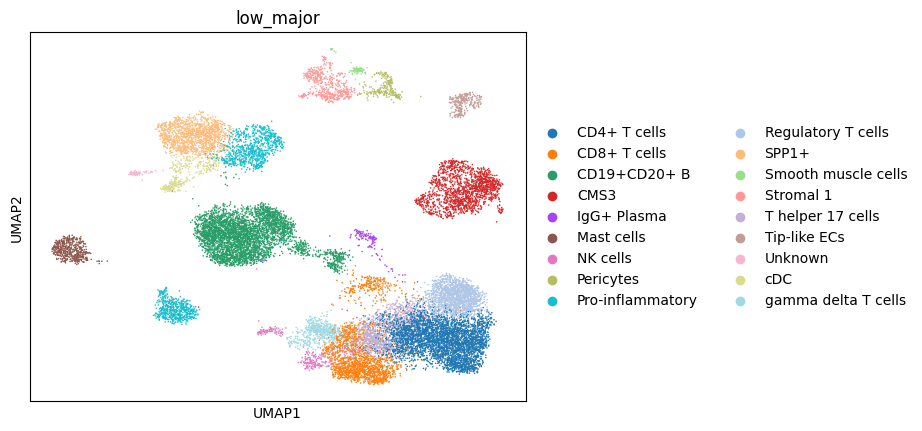

In [25]:
sc.pl.umap(adata, color = ['low_major'], s = 5)

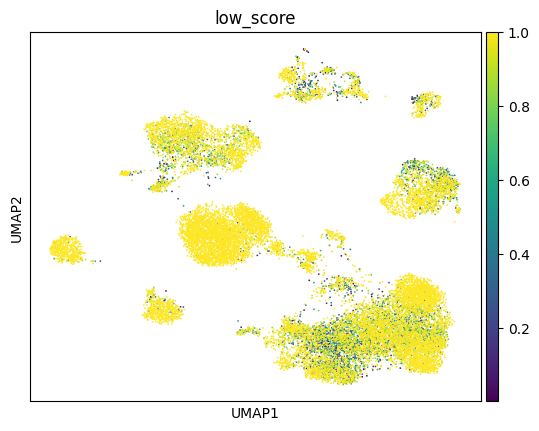

In [26]:
sc.pl.umap(adata, color = ['low_score' ])